# Sesión 3. Deep Learning aplicado a Visión Artificial

<a href="https://colab.research.google.com/github/ramajoballester/UC3M-PIC/blob/main/notebooks/03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Redes Neuronales Convolucionales (CNN)

In [2]:
# Ejecutar esta celda ÚNICAMENTE si se está trabajando en GOOGLE COLAB

if 'google.colab' in str(get_ipython()):
    import os

    ! git clone https://github.com/ramajoballester/UC3M-PIC.git
    ! pip install uc3m-pic
    os.chdir('UC3M-PIC')
    os.chdir('notebooks')
    print('UC3M-PIC instalado en Colab')
else:
    print('Ejecutando en local')

Ejecutando en local


In [ ]:
%load_ext autoreload
%load_ext tensorboard

%autoreload 2

import copy
import os
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib_inline
import numpy as np
import thop
import torch
import torch.nn.functional as F
import torchmetrics
import torchvision
import uc3m_pic
from uc3m_pic import utils
import wandb
from sklearn.model_selection import StratifiedShuffleSplit
from torch import nn

# from tensorboard.plugins.hparams import api as hp
# from tensorboard.plugins.hparams.api import HParam
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
from tqdm.auto import tqdm

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

student = uc3m_pic.eval.User('100100100')
student.login()
student.open_by_url('https://docs.google.com/spreadsheets/d/1sGXOQo0WgKjllJSdE778EBhU63f-wmSrazeINSnl1a0/edit?usp=sharing')

## Operación de convolución

Las capas totalmente conectadas (*fully-connected*) que se estudiaron previamente tienen una serie de problemas inherentes a su naturaleza. Por ejemplo, si los datos de entrada fueran fotografías de un megapíxel, significaría que cada entrada a la red tendría un millón de dimensiones. Incluso una reducción agresiva a mil dimensiones ocultas requeriría una capa totalmente conectada caracterizada por $10^6 \times 10^3 = 10^9$ parámetros. A menos que se disponga de un gran número de GPU y una extraordinaria paciencia, aprender los parámetros de esta red puede resultar inviable.

Además de ello, un método para reconocer objetos en una imagen debería ser capaz de reconocerlos independientemente de su posición en la imagen. Por ejemplo, si se tiene una imagen de un gato, debería ser capaz de reconocerlo independientemente de si se encuentra en la esquina superior izquierda o en la esquina inferior derecha o de si se encuentra rotado. Es decir, debería ser invariante a la traslación y a la rotación. Por otro lado, normalmente los objetos están definidos principalmente por los elementos más próximos a ellos en lugar de los más alejados, por lo que sería deseable que también se cumpliera el principio de localidad, es decir, que el modelo se centrara en las características locales en un entorno de rango $\pm\Delta$

En matemáticas, la *convolución* entre dos funciones, por ejemplo, $f, g: \mathbb{R}^d \to \mathbb{R}$ se define como:

$$(f * g)(x) = \int f(z) g(x-z) dz$$

Siempre que se tengan elementos discretos, la integral se convierte en una suma. Por ejemplo, para vectores del conjunto de vectores de dimensión infinita con índice $a \in \mathbb{Z}_0^{+}$ se obtiene la siguiente definición:

$$(f * g)(i) = \sum_a f(a) g(i-a)$$

Para tensores bidimensionales, se tiene un sumatorio correspondiente con índices $(a, b)$ para $f$ y $(i-a, j-b)$ para $g$, respectivamente:

$$(f * g)(i, j) = \sum_a\sum_b f(a, b) g(i-a, j-b)$$

Sólo hay un problema con este enfoque. Hasta ahora, se ha ignorado por completo que las imágenes constan de tres canales: rojo, verde y azul. En resumen, las imágenes no son objetos bidimensionales, sino tensores de tercer orden, caracterizados por una altura, una anchura y un número de canales. Para permitir múltiples canales tanto en las entradas ($\mathsf{X}$) como en las representaciones ocultas (o *feature maps*) ($\mathsf{H}$), se puede añadir una cuarta coordenada a $\mathsf{V}$: $[\mathsf{V}]_{a, b, c, d}$. Juntando todo, incluyendo el rango $\Delta$ en el cual se desea aplicar esta convolución se obtiene:

$$[\mathsf{H}]_{i,j,d} = \sum_{a = -\Delta}^{\Delta} \sum_{b = -\Delta}^{\Delta} \sum_c [\mathsf{V}]_{a, b, c, d} [\mathsf{X}]_{i+a, j+b, c}$$

In [4]:
a = torch.arange(0, 9).reshape(3, 3)
a

tensor([[0, 1, 2],
        [3, 4, 5],
        [6, 7, 8]])

In [5]:
kernel = torch.arange(0, 4).reshape(2, 2)
kernel

tensor([[0, 1],
        [2, 3]])

<img src="https://raw.githubusercontent.com/ramajoballester/UC3M-PIC/main/data/content/correlation.svg"
    style="background-color:white; display:block; margin-left:auto; margin-right:auto; width:50vw"/>

In [ ]:
0 * 0 + 1 * 1 + 3 * 2 + 4 * 3

19

In [ ]:
F.conv2d(
    a.view(1, 1, a.shape[0], a.shape[1]),
    kernel.view(1, 1, kernel.shape[0], kernel.shape[1]),
)

tensor([[[[19, 25],
          [37, 43]]]])

In [8]:
a.reshape((1, 1, 3, 3)).shape

torch.Size([1, 1, 3, 3])

## Detección de bordes

### Verticales

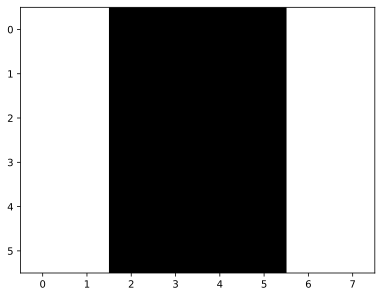

In [ ]:
x = torch.ones((6, 8))
x[:, 2:6] = 0
plt.imshow(x, cmap='gray')

In [22]:
kernel_v = torch.tensor([[1.0, -1.0]])
kernel_v

tensor([[ 1., -1.]])

In [23]:
# Añadimos dos dimensiones (requisito de conv2d)
print(x.shape)
print(x.expand(1, 1, -1, -1).shape)

torch.Size([6, 8])
torch.Size([1, 1, 6, 8])


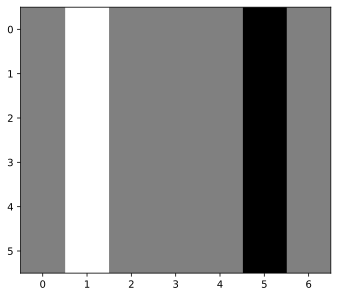

In [ ]:
plt.imshow(
    F.conv2d(x.expand(1, 1, -1, -1), kernel_v.expand(1, 1, -1, -1))[0, 0],
    cmap='gray',
)

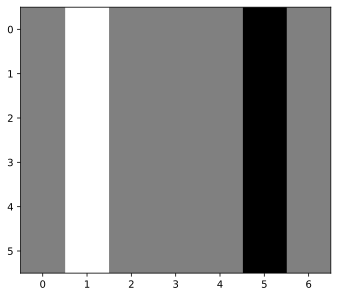

In [ ]:
# Equivalente
conv = F.conv2d(
    x.view(1, 1, x.shape[0], x.shape[1]),
    kernel_v.view(1, 1, kernel_v.shape[0], kernel_v.shape[1]),
)
plt.imshow(conv[0, 0], cmap='gray')

### Horizontales

In [ ]:
kernel_h = torch.tensor([[1.0], [-1.0]])
kernel_h

tensor([[ 1.],
        [-1.]])

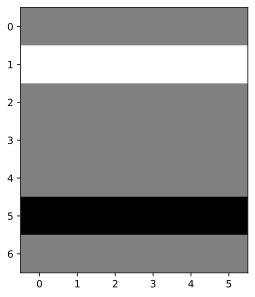

In [ ]:
x_transp = x.T
plt.imshow(
    F.conv2d(x_transp.expand(1, 1, -1, -1), kernel_h.expand(1, 1, -1, -1))[
        0, 0
    ],
    cmap='gray',
)

### Diagonales

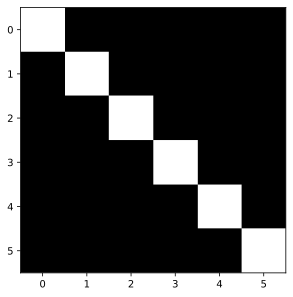

In [ ]:
x_ident = torch.eye(6)
plt.imshow(x_ident, cmap='gray')

In [ ]:
# SOLUCIÓN:


In [ ]:
kernel_d = ...
kernel_d

In [ ]:
plt.imshow(
    F.conv2d(x_ident.expand(1, 1, -1, -1), kernel_d.expand(1, 1, -1, -1))[
        0, 0
    ],
    cmap='gray',
)

## Carga de imágenes

In [ ]:
batch_size = 32

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

# Cargamos el dataset (entrenamiento y test)
data_path = os.path.join('..', 'data')
mnist_train = torchvision.datasets.MNIST(
    root=data_path, train=True, transform=transform, download=True
)
mnist_test = torchvision.datasets.MNIST(
    root=data_path, train=False, transform=transform, download=True
)

train_dataloader = torch.utils.data.DataLoader(
    mnist_train, batch_size, shuffle=True
)
test_dataloader = torch.utils.data.DataLoader(
    mnist_test, batch_size, shuffle=False
)
labels = mnist_train.classes
num_outputs = len(labels)

In [50]:
x_train, y_train = next(iter(test_dataloader))
x = x_train[3, 0]

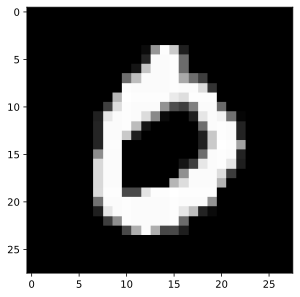

In [ ]:
plt.imshow(x, cmap='gray')
plt.show()

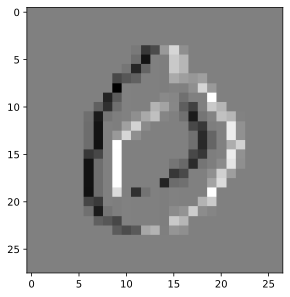

In [ ]:
# El kernel puede ser el horizontal (kernel_h), vertical (kernel_v) o diagonal (kernel_d
kernel = kernel_v
img = F.conv2d(
    x.view(1, 1, x.shape[0], x.shape[1]),
    kernel.view(1, 1, kernel.shape[0], kernel.shape[1]),
)
plt.imshow(img[0, 0], cmap='gray')

## Padding

In [55]:
a = torch.arange(0, 9).reshape(3, 3)
a

tensor([[0, 1, 2],
        [3, 4, 5],
        [6, 7, 8]])

In [56]:
# Izquierda, derecha, arriba, abajo
a_pad = F.pad(a, (1, 1, 1, 1))
a_pad

tensor([[0, 0, 0, 0, 0],
        [0, 0, 1, 2, 0],
        [0, 3, 4, 5, 0],
        [0, 6, 7, 8, 0],
        [0, 0, 0, 0, 0]])

In [57]:
kernel = torch.arange(0, 4).reshape(2, 2)
kernel

tensor([[0, 1],
        [2, 3]])

In [ ]:
F.conv2d(
    a_pad.view(1, 1, a_pad.shape[0], a_pad.shape[1]),
    kernel.view(1, 1, kernel.shape[0], kernel.shape[1]),
)

tensor([[[[ 0,  3,  8,  4],
          [ 9, 19, 25, 10],
          [21, 37, 43, 16],
          [ 6,  7,  8,  0]]]])

<img src="https://raw.githubusercontent.com/ramajoballester/UC3M-PIC/main/data/content/conv-pad.svg"
    style="background-color:white; display:block; margin-left:auto; margin-right:auto; width:60vw"/>

In [ ]:
F.conv2d(
    a.view(1, 1, a.shape[0], a.shape[1]),
    kernel.view(1, 1, kernel.shape[0], kernel.shape[1]),
    padding=(1, 1),
)

tensor([[[[ 0,  3,  8,  4],
          [ 9, 19, 25, 10],
          [21, 37, 43, 16],
          [ 6,  7,  8,  0]]]])

## Stride

In [ ]:
F.conv2d(
    a_pad.view(1, 1, a_pad.shape[0], a_pad.shape[1]),
    kernel.view(1, 1, kernel.shape[0], kernel.shape[1]),
    stride=(3, 2),
)

tensor([[[[0, 8],
          [6, 8]]]])

<img src="https://raw.githubusercontent.com/ramajoballester/UC3M-PIC/main/data/content/conv-stride.svg"
    style="background-color:white; display:block; margin-left:auto; margin-right:auto; width:50vw"/>

In [ ]:
class ConvModelStride(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 5, stride=2, padding=2)
        self.conv2 = nn.Conv2d(16, 64, 5, stride=2, padding=2)
        self.conv3 = nn.Conv2d(64, 8, 3)
        self.flat = nn.Flatten()
        self.linear = nn.Linear(8 * 5 * 5, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.flat(x)
        x = self.linear(x)

        return x

In [84]:
model_stride = ConvModelStride()

In [ ]:
# Salida primera capa
utils.conv2d_output_size(input_size=28, kernel_size=5, padding=2, stride=2)

14

In [ ]:
# Salida segunda capa
utils.conv2d_output_size(input_size=14, kernel_size=5, padding=2, stride=2)

7

In [ ]:
# Salida tercera capa
utils.conv2d_output_size(input_size=7, kernel_size=3)

5

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
summary(model_stride.to(device), (1, 28, 28))
flops, params = thop.profile(
    model_stride, verbose=False, inputs=(torch.randn(1, 1, 28, 28).to(device),)
)
(flops, params) = thop.clever_format([flops, params])
print(f'FLOPs: {flops}, params: {params}')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 14, 14]             416
            Conv2d-2             [-1, 64, 7, 7]          25,664
            Conv2d-3              [-1, 8, 5, 5]           4,616
           Flatten-4                  [-1, 200]               0
            Linear-5                   [-1, 10]           2,010
Total params: 32,706
Trainable params: 32,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.12
Estimated Total Size (MB): 0.18
----------------------------------------------------------------
FLOPs: 1.45M, params: 32.71K


## Pooling

In [71]:
a = torch.arange(0, 9, dtype=torch.float32).reshape(3, 3)
a

tensor([[0., 1., 2.],
        [3., 4., 5.],
        [6., 7., 8.]])

In [72]:
F.max_pool2d(a.unsqueeze(0), (2, 2), stride=1)

tensor([[[4., 5.],
         [7., 8.]]])

<img src="https://raw.githubusercontent.com/ramajoballester/UC3M-PIC/main/data/content/pooling.svg"
    style="background-color:white; display:block; margin-left:auto; margin-right:auto; width:50vw"/>

## Múltiples canales de entrada y salida

In [ ]:
a = torch.stack(
    [torch.arange(0, 9).reshape(3, 3), torch.arange(1, 10).reshape(3, 3)]
)
a

tensor([[[0, 1, 2],
         [3, 4, 5],
         [6, 7, 8]],

        [[1, 2, 3],
         [4, 5, 6],
         [7, 8, 9]]])

In [ ]:
kernel = torch.stack(
    [torch.arange(0, 4).reshape(2, 2), torch.arange(1, 5).reshape(2, 2)]
)
kernel

tensor([[[0, 1],
         [2, 3]],

        [[1, 2],
         [3, 4]]])

In [75]:
F.conv2d(a.unsqueeze(0), kernel.unsqueeze(0))

tensor([[[[ 56,  72],
          [104, 120]]]])

<img src="https://raw.githubusercontent.com/ramajoballester/UC3M-PIC/main/data/content/conv-multi-in.svg"
    style="background-color:white; display:block; margin-left:auto; margin-right:auto; width:60vw"/>

## Convolución 1x1

In [ ]:
a = torch.arange(0, 3 * 3 * 3).reshape(3, 3, 3)
a

tensor([[[ 0,  1,  2],
         [ 3,  4,  5],
         [ 6,  7,  8]],

        [[ 9, 10, 11],
         [12, 13, 14],
         [15, 16, 17]],

        [[18, 19, 20],
         [21, 22, 23],
         [24, 25, 26]]])

In [77]:
kernel = torch.arange(0, 6).reshape(2, 3, 1, 1)
kernel

tensor([[[[0]],

         [[1]],

         [[2]]],


        [[[3]],

         [[4]],

         [[5]]]])

In [78]:
F.conv2d(a.unsqueeze(0), kernel)

tensor([[[[ 45,  48,  51],
          [ 54,  57,  60],
          [ 63,  66,  69]],

         [[126, 138, 150],
          [162, 174, 186],
          [198, 210, 222]]]])

<img src="https://raw.githubusercontent.com/ramajoballester/UC3M-PIC/main/data/content/conv-1x1.svg"
    style="background-color:white; display:block; margin-left:auto; margin-right:auto; width:50vw"/>

## Número de parámetros

In [115]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 5, stride=2, padding=2)
        self.conv2 = nn.Conv2d(16, 64, 3, stride=2, padding=1)
        self.maxpool = nn.MaxPool2d(3, stride=2)
        self.avgpool = nn.AvgPool2d(2)
        self.linear = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = self.avgpool(x)
        x = F.softmax(self.linear(torch.flatten(x, start_dim=1)), dim=-1)

        return x

In [116]:
model = CNN()

In [ ]:
summary(model.to(torch.device('cuda')), (1, 28, 28))
flops, params = thop.profile(
    model, verbose=False, inputs=(torch.randn(1, 1, 28, 28).to(device),)
)
(flops, params) = thop.clever_format([flops, params])
print(f'FLOPs: {flops}, params: {params}')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 14, 14]             416
         MaxPool2d-2             [-1, 16, 6, 6]               0
            Conv2d-3             [-1, 64, 3, 3]           9,280
         AvgPool2d-4             [-1, 64, 1, 1]               0
            Linear-5                   [-1, 10]             650
Total params: 10,346
Trainable params: 10,346
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 0.04
Estimated Total Size (MB): 0.08
----------------------------------------------------------------
FLOPs: 162.05K, params: 10.35K


In [ ]:
w1 = 1 * 16 * 5 * 5 + 16
w1

416

In [ ]:
w2 = 16 * 64 * 3 * 3 + 64
w2

9280

In [ ]:
w3 = 64 * 10 + 10
w3

650

In [124]:
w1 + w2 + w3

10346

# Dataset EuroSAT

In [ ]:
class EuroSATModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.conv2 = nn.Conv2d(16, 64, 5, stride=2)
        self.conv3 = nn.Conv2d(64, 128, 3, stride=2)
        self.linear1 = nn.Linear(128 * 5 * 5, 256)
        self.linear2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=(3, 3), stride=2))
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=(3, 3), stride=1))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        out = F.softmax(self.linear2(x), dim=-1)

        return out

In [ ]:
# Utilizar si es necesario
utils.conv2d_output_size(
    input_size=64,
    kernel_size=5,
    padding=0,
    stride=1,
    pool_kernel_size=3,
    pool_stride=2,
)

29

In [ ]:
# Probar que las dimensiones de las capas son correctas
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EuroSATModel().to(device)
summary(model, (3, 64, 64))
# Calcular FLOPs
flops, params = thop.profile(
    model, verbose=False, inputs=(torch.randn(1, 3, 64, 64).to(device),)
)
(flops, params) = thop.clever_format([flops, params])
print(f'FLOPs: {flops}, params: {params}')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 60, 60]           1,216
            Conv2d-2           [-1, 64, 13, 13]          25,664
            Conv2d-3            [-1, 128, 5, 5]          73,856
            Linear-4                  [-1, 256]         819,456
            Linear-5                   [-1, 10]           2,570
Total params: 922,762
Trainable params: 922,762
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 0.55
Params size (MB): 3.52
Estimated Total Size (MB): 4.12
----------------------------------------------------------------
FLOPs: 11.31M, params: 922.76K


/home/breaststroker/miniconda3/envs/uc3m-pic.private/lib/python3.11/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


In [ ]:
# Carga del dataset

batch_size = 32

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

# Fix SSL Error when downloading dataset
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

data_path = os.path.join('..', 'data')
eurosat_dataset = torchvision.datasets.EuroSAT(
    root=data_path, transform=transform, download=True
)

# No modificar la semilla de aleatoriedad (random_state)
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
train_idx, test_idx = next(
    strat_split.split(eurosat_dataset, eurosat_dataset.targets)
)
train_dataset = torch.utils.data.Subset(eurosat_dataset, train_idx)
test_dataset = torch.utils.data.Subset(eurosat_dataset, test_idx)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size, shuffle=True
)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size, shuffle=False
)

labels = eurosat_dataset.classes
num_outputs = len(labels)

100%|██████████| 94280567/94280567 [01:03<00:00, 1479440.50it/s]


Extracting ../data/eurosat/EuroSAT.zip to ../data/eurosat


In [7]:
x, y = next(iter(train_dataloader))

Highway


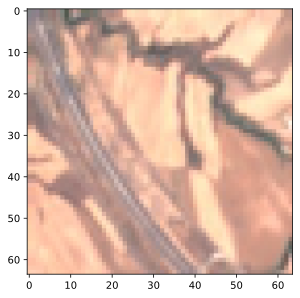

In [141]:
# Visualización del dataset
idx = np.random.randint(0, len(x))
plt.imshow(x[idx].permute(1, 2, 0))
print(labels[y[idx]])

# Ejercicio 3: EuroSAT

In [ ]:
class EuroSATModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.conv2 = nn.Conv2d(16, 64, 5, stride=2)
        self.conv3 = nn.Conv2d(64, 128, 3, stride=2)
        self.linear1 = nn.Linear(128 * 5 * 5, 256)
        self.linear2 = nn.Linear(256, 10)

    def forward(self, x):
        # Las capas que no contienen parámetros se pueden utilizar directamente
        # en el forward con la API funcional de pytorch, sin necesidad de
        # definirlas en el constructor
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=(3, 3), stride=2))
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=(3, 3), stride=1))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        out = F.softmax(self.linear2(x), dim=-1)

        return out


# GPU o CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Modelo personalizado
model = EuroSATModel().to(device)

# Learning rate
lr = 0.0001
# Número de epochs de entrenamiento
num_epochs = 20
# Batch size
batch_size = 256
# Optimizador. Otras opciones: Adam, RMSProp, etc.
# Ver https://pytorch.org/docs/stable/optim.html#algorithms
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
# Fix SSL Error when downloading dataset
import ssl

ssl._create_default_https_context = ssl._create_unverified_context
data_path = os.path.join('..', 'data')
eurosat_dataset = torchvision.datasets.EuroSAT(
    root=data_path, transform=transform, download=True
)
# No modificar la semilla de aleatoriedad (random_state)
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
train_idx, test_idx = next(
    strat_split.split(eurosat_dataset, eurosat_dataset.targets)
)
train_dataset = torch.utils.data.Subset(eurosat_dataset, train_idx)
test_dataset = torch.utils.data.Subset(eurosat_dataset, test_idx)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size, shuffle=True, num_workers=2
)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size, shuffle=False, num_workers=2
)
labels = eurosat_dataset.classes
num_outputs = len(labels)

# Función de pérdida
loss_fn = nn.NLLLoss(reduction='sum')
# Métrica de precisión
metrics_fn = torchmetrics.classification.MulticlassAccuracy(
    num_classes=num_outputs, average='micro'
).to(device)

best_acc = 0
train_loss_history = []
train_acc_history = []
test_loss_history = []
test_acc_history = []

for epoch in tqdm(range(num_epochs)):
    utils.train(model, train_dataloader, loss_fn, optimizer)

    train_loss, train_acc = utils.test(
        model, train_dataloader, loss_fn, metrics_fn
    )
    test_loss, test_acc = utils.test(
        model, test_dataloader, loss_fn, metrics_fn
    )

    if best_acc <= test_acc:
        best_acc = test_acc
        best_model = copy.deepcopy(model)

    # Almacenamos los valores de pérdida y precisión en cada epoch
    train_loss_history.append(train_loss.cpu())
    train_acc_history.append(train_acc.cpu())
    test_loss_history.append(test_loss.cpu())
    test_acc_history.append(test_acc.cpu())

    print(
        f'Epoch {epoch}, Precisión (train): {train_acc:.4f}, Loss (train): {train_loss:.4f}'
    )
    print(
        f'Epoch {epoch}, Precisión (test):  {test_acc:.4f}, Loss (test):  {test_loss:.4f}'
    )

In [ ]:
# Gráfica de la evolución de la pérdida y la precisión
plt.subplot(2, 1, 1)
plt.plot(train_loss_history, label='train')
plt.plot(test_loss_history, label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(train_acc_history, label='train')
plt.plot(test_acc_history, label='test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Evaluar modelo y subir resultados al leaderboard
student.submit(best_model, exercise=3)

# Mejora del rendimiento

## LR scheduler

[LR schedulers Pytorch](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate)

In [ ]:
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer=optimizer, step_size=10, gamma=0.1
)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(
    optimizer=optimizer, gamma=0.95
)

In [ ]:
# Integración en el bucle de entrenamiento (no ejecutar)
for x, y in train_dataloader:
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    y_pred = model(x)
    loss = loss_fn(y_pred, y)
    loss.backward()
    optimizer.step()
### LR scheduler fuera del bucle
lr_scheduler.step()
###

## Optimizadores 

[Optimizadores Pytorch](https://pytorch.org/docs/stable/optim.html#algorithms)


Choi, D., Shallue, C. J., Nado, Z., Lee, J., Maddison, C. J., & Dahl, G. E. (2019). **On empirical comparisons of optimizers for deep learning.**  arXiv preprint arXiv:1910.05446. [Paper](https://arxiv.org/pdf/1910.05446.pdf)

<img src="https://raw.githubusercontent.com/ramajoballester/UC3M-PIC/main/data/content/optimizers.png"
    style="background-color:white; display:block; margin-left:auto; margin-right:auto; width:90vw"/>

## Aumentación de datos

Descargar dataset [Imagenette-320px](https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-320.tgz), guardar en la carpeta `data` y extraer:

In [6]:
# Check if ../data/imagenette2-320.tgz exists, if not download it
data_path = os.path.join('..', 'data', 'imagenette2-320')
if not os.path.isdir(data_path):
    ! wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-320.tgz -P ../data
    ! tar -xzf ../data/imagenette2-320.tgz -C ../data
else:
    print('Imagenette dataset already downloaded')

Imagenette dataset already downloaded


In [7]:
# Diferentes transforms en train y test
train_transform = torchvision.transforms.Compose(
    [
        # torchvision.transforms.ToTensor(),
        torchvision.transforms.Resize((320, 425), antialias=True),
        torchvision.transforms.RandomResizedCrop(200),
        torchvision.transforms.RandomHorizontalFlip(0.25),
        torchvision.transforms.RandomVerticalFlip(0.25),
        torchvision.transforms.RandomAffine(15),
        # torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

test_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Resize((320, 425), antialias=True),
        # torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

In [9]:
batch_size = 32
train_path = os.path.join('..', 'data', 'imagenette2-320', 'train')
test_path = os.path.join('..', 'data', 'imagenette2-320', 'val')
train_dataset = torchvision.datasets.ImageFolder(
    root=train_path, transform=train_transform
)
test_dataset = torchvision.datasets.ImageFolder(
    root=test_path, transform=test_transform
)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size, shuffle=True, num_workers=4
)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size, shuffle=True, num_workers=4
)
labels = [
    'tench',
    'English springer',
    'cassette player',
    'chain saw',
    'church',
    'French horn',
    'garbage truck',
    'gas pump',
    'golf ball',
    'parachute',
]

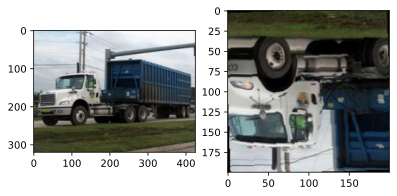

In [55]:
x, y = next(iter(test_dataloader))

x_transf = train_transform(x)

# Aplicar transformaciones
fig, ax = plt.subplots(1, 2)
fig.size = (10, 10)
ax[0].imshow(x[0].permute(1, 2, 0))
ax[1].imshow(x_transf[0].permute(1, 2, 0))
plt.show()

## Regularización

### L1, L2

In [39]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.1)

### Dropout

In [ ]:
class CNNDropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 5)
        self.conv2 = nn.Conv2d(16, 64, 5)
        self.conv3 = nn.Conv2d(64, 8, 5)
        self.flat = nn.Flatten()
        self.linear = nn.Linear(8 * 16 * 16, 47)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.dropout(x)
        # Equivalente con API funcional
        # x = F.dropout2d(x, p=0.5)
        x = F.relu(self.conv3(x))
        x = self.flat(x)
        x = self.linear(x)

        return x

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
summary(CNNDropout().to(device), (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 24, 24]             416
            Conv2d-2           [-1, 64, 20, 20]          25,664
           Dropout-3           [-1, 64, 20, 20]               0
            Conv2d-4            [-1, 8, 16, 16]          12,808
           Flatten-5                 [-1, 2048]               0
            Linear-6                   [-1, 47]          96,303
Total params: 135,191
Trainable params: 135,191
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.49
Params size (MB): 0.52
Estimated Total Size (MB): 1.01
----------------------------------------------------------------


### Batch normalization

In [ ]:
# Create the same model with batch normalization
class CNNBN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 5)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 64, 5)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 8, 5)
        self.bn3 = nn.BatchNorm2d(8)
        self.flat = nn.Flatten()
        self.linear = nn.Linear(8 * 16 * 16, 47)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.flat(x)
        x = self.linear(x)

        return x

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
summary(CNNBN().to(device), (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 24, 24]             416
       BatchNorm2d-2           [-1, 16, 24, 24]              32
            Conv2d-3           [-1, 64, 20, 20]          25,664
       BatchNorm2d-4           [-1, 64, 20, 20]             128
            Conv2d-5            [-1, 8, 16, 16]          12,808
       BatchNorm2d-6            [-1, 8, 16, 16]              16
           Flatten-7                 [-1, 2048]               0
            Linear-8                   [-1, 47]          96,303
Total params: 135,367
Trainable params: 135,367
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.58
Params size (MB): 0.52
Estimated Total Size (MB): 1.10
----------------------------------------------------------------


# Dataset Imagenette

In [ ]:
batch_size = 64

transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Resize((320, 425), antialias=True),
    ]
)

# Carga del dataset desde archivos locales
train_path = os.path.join('..', 'data', 'imagenette2-320', 'train')
test_path = os.path.join('..', 'data', 'imagenette2-320', 'val')
train_dataset = torchvision.datasets.ImageFolder(
    root=train_path, transform=transform
)
test_dataset = torchvision.datasets.ImageFolder(
    root=test_path, transform=transform
)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size, shuffle=True
)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size, shuffle=False
)

labels = [
    'tench',
    'English springer',
    'cassette player',
    'chain saw',
    'church',
    'French horn',
    'garbage truck',
    'gas pump',
    'golf ball',
    'parachute',
]

In [45]:
x, y = next(iter(train_dataloader))

chain saw


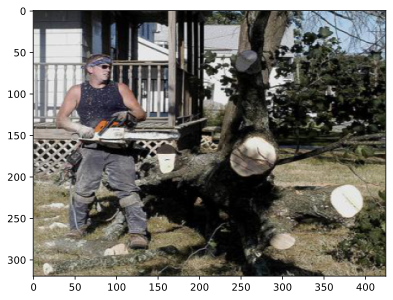

In [47]:
# Visualización del dataset
idx = np.random.randint(0, len(x))
plt.imshow(x[idx].permute(1, 2, 0))
print(labels[y[idx]])

# Ajustar modelo

In [ ]:
class ImagenetteModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=(11, 11), stride=(3, 4))
        self.conv2 = nn.Conv2d(64, 256, 5, stride=2)
        self.conv3 = nn.Conv2d(256, 1024, 3)
        self.maxpool1 = nn.MaxPool2d(3, stride=3)
        self.maxpool2 = nn.MaxPool2d(3, stride=2)
        self.maxpool3 = nn.MaxPool2d(3, stride=2)
        self.linear1 = nn.Linear(1024 * 2 * 2, 256)
        self.linear2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.maxpool1(self.conv1(x)))
        x = F.relu(self.maxpool2(self.conv2(x)))
        x = F.relu(self.maxpool3(self.conv3(x)))

        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        out = F.softmax(self.linear2(x), dim=-1)

        return out

In [ ]:
utils.conv2d_output_size(
    input_size=320, kernel_size=11, stride=3, pool_kernel_size=3, pool_stride=3
)

34

In [ ]:
# Probar que las dimensiones de las capas son correctas
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ImagenetteModel().to(device)
summary(model, (3, 320, 425))
# Calcular FLOPs
flops, params = thop.profile(
    model, verbose=False, inputs=(torch.randn(1, 3, 320, 425).to(device),)
)
(flops, params) = thop.clever_format([flops, params])
print(f'FLOPs: {flops}, params: {params}')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 104, 104]          23,296
         MaxPool2d-2           [-1, 64, 34, 34]               0
            Conv2d-3          [-1, 256, 15, 15]         409,856
         MaxPool2d-4            [-1, 256, 7, 7]               0
            Conv2d-5           [-1, 1024, 5, 5]       2,360,320
         MaxPool2d-6           [-1, 1024, 2, 2]               0
            Linear-7                  [-1, 256]       1,048,832
            Linear-8                   [-1, 10]           2,570
Total params: 3,844,874
Trainable params: 3,844,874
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 1.56
Forward/backward pass size (MB): 6.61
Params size (MB): 14.67
Estimated Total Size (MB): 22.83
----------------------------------------------------------------
FLOPs: 403.47M, params: 3.84M


# Ejercicio 4: Imagenette

In [ ]:
class ImagenetteModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=(11, 11), stride=(3, 4))
        self.conv2 = nn.Conv2d(32, 128, 5, stride=2)
        self.conv3 = nn.Conv2d(128, 256, 3, stride=2)
        self.maxpool1 = nn.MaxPool2d(5, stride=3)
        self.maxpool2 = nn.MaxPool2d(3, stride=2)
        self.maxpool3 = nn.MaxPool2d(3, stride=1)
        self.linear1 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.maxpool1(self.conv1(x)))
        x = F.relu(self.maxpool2(self.conv2(x)))
        x = F.relu(self.maxpool3(self.conv3(x)))

        x = torch.flatten(x, start_dim=1)
        out = F.softmax(self.linear1(x), dim=-1)

        return out


# GPU o CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Modelo personalizado
model = ImagenetteModel().to(device)

# Learning rate
lr = 0.0001
# Número de epochs de entrenamiento
num_epochs = 5
# Batch size
batch_size = 256
# Optimizador. Otras opciones: Adam, RMSProp, etc.
# Ver https://pytorch.org/docs/stable/optim.html#algorithms
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Carga del dataset (entrenamiento y test)
train_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Resize((320, 425), antialias=True),
        torchvision.transforms.RandomHorizontalFlip(0.25),
        torchvision.transforms.RandomVerticalFlip(0.25),
        torchvision.transforms.RandomAffine(15),
    ]
)
test_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Resize((320, 425), antialias=True),
    ]
)
# Load imagenette dataset from local files
train_path = os.path.join('..', 'data', 'imagenette2-320', 'train')
test_path = os.path.join('..', 'data', 'imagenette2-320', 'val')
train_dataset = torchvision.datasets.ImageFolder(
    root=train_path, transform=transform
)
test_dataset = torchvision.datasets.ImageFolder(
    root=test_path, transform=test_transform
)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size, shuffle=True, num_workers=4
)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size, shuffle=False, num_workers=4
)
labels = [
    'tench',
    'English springer',
    'cassette player',
    'chain saw',
    'church',
    'French horn',
    'garbage truck',
    'gas pump',
    'golf ball',
    'parachute',
]
num_outputs = len(labels)

# Función de pérdida
loss_fn = nn.NLLLoss(reduction='sum')
# Métrica de precisión
metrics_fn = torchmetrics.classification.MulticlassAccuracy(
    num_classes=num_outputs, average='micro'
).to(device)
# LR scheduler
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

best_acc = 0
train_loss_history = []
train_acc_history = []
test_loss_history = []
test_acc_history = []
lr_history = []

for epoch in tqdm(range(num_epochs)):
    utils.train(model, train_dataloader, loss_fn, optimizer, lr_scheduler)

    train_loss, train_acc = utils.test(
        model, train_dataloader, loss_fn, metrics_fn
    )
    test_loss, test_acc = utils.test(
        model, test_dataloader, loss_fn, metrics_fn
    )

    if best_acc <= test_acc:
        best_acc = test_acc
        best_model = copy.deepcopy(model)

    # Almacenamos los valores de pérdida y precisión en cada epoch
    train_loss_history.append(train_loss.cpu())
    train_acc_history.append(train_acc.cpu())
    test_loss_history.append(test_loss.cpu())
    test_acc_history.append(test_acc.cpu())
    lr_history.append(lr_scheduler.get_last_lr()[0])

    print(
        f'Epoch {epoch}, Precisión (train): {train_acc:.4f}, Loss (train): {train_loss:.4f}'
    )
    print(
        f'Epoch {epoch}, Precisión (test):  {test_acc:.4f}, Loss (test):  {test_loss:.4f}'
    )

In [ ]:
# Gráfica de la evolución de la pérdida y la precisión
plt.subplot(3, 1, 1)
plt.plot(train_loss_history, label='train')
plt.plot(test_loss_history, label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(train_acc_history, label='train')
plt.plot(test_acc_history, label='test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

plt.subplot(3, 1, 3)
plt.plot(lr_history)
plt.xlabel('Epoch')
plt.ylabel('Learning rate')
plt.tight_layout()
plt.show()

In [ ]:
# Evaluar modelo y subir resultados al leaderboard
student.submit(best_model, exercise=4)

# Optimización de entrenamientos

El objetivo de este ejercicio es optimizar los hiperparámetros de los entrenamientos de cada modelo para poder comparar entre sí los mejores resultados de cada arquitectura

## Ejercicio 1

### Perceptrón unicapa

In [ ]:
%tensorboard --logdir ../runs

# Truco para visualizar en pestaña timeseries. Regex: ^((?!hparams).)*$

In [5]:
class Model_1(torch.nn.Module):
    """
    Modelo de regresión softmax
    """

    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(28**2, 10)

    def forward(self, x):
        # Flatten x with torch.flatten
        x = torch.flatten(x, start_dim=1)
        out = self.linear1(x)
        out = F.softmax(out, dim=-1)
        return out

In [ ]:
# En este ejercicio vamos a ir probando diferentes valores de learning rate,
# batch size y optimizador para ver cómo afectan al entrenamiento.

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Modelo personalizado
model = Model_1().to(device)

## HIPERPARÁMETROS
# Learning rate
lr = 0.001
# Número de epochs de entrenamiento
num_epochs = 40
# Batch size
batch_size = 64

# Optimizador. Otras opciones: Adam, RMSProp, etc.
# Ver https://pytorch.org/docs/stable/optim.html#algorithms
# optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


# Creamos summary writer
exp_name = 'Ejercicio_1'
date = datetime.now().strftime('%Y%m%d-%H%M%S')
log_dir = os.path.join('..', 'runs', exp_name, date)
writer = SummaryWriter(log_dir=log_dir)


# Transformaciones del dataset
train_transf = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor()]
)
test_transf = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor()]
)

# Cargamos el dataset (entrenamiento y test)
data_path = os.path.join('..', 'data')
mnist_train = torchvision.datasets.FashionMNIST(
    root=data_path, train=True, transform=train_transf, download=True
)
mnist_test = torchvision.datasets.FashionMNIST(
    root=data_path, train=False, transform=test_transf, download=True
)

# Reducimos el dataset de forma balanceada para hacer pruebas más rápidas
n_samples = 5000
train_dataset, test_dataset = utils.subsample_dataset(
    (mnist_train, mnist_test), n_samples
)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size, shuffle=True, num_workers=4
)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size, shuffle=False, num_workers=4
)

labels = mnist_train.classes
num_outputs = len(labels)


# Creamos el modelo, la funcione de pérdida y la métrica de precisión
loss_fn = nn.NLLLoss(reduction='sum')
metrics_fn = torchmetrics.classification.MulticlassAccuracy(
    num_classes=num_outputs, average='micro'
).to(device)

best_train_acc = 0
best_test_acc = 0
best_train_loss = 1e10
best_test_loss = 1e10
train_loss_history = []
train_acc_history = []
test_loss_history = []
test_acc_history = []

for epoch in tqdm(range(num_epochs)):
    # Entrenamiento
    utils.train(model, train_dataloader, loss_fn, optimizer)

    # Evaluación
    train_loss, train_acc = utils.test(
        model, train_dataloader, loss_fn, metrics_fn
    )
    test_loss, test_acc = utils.test(
        model, test_dataloader, loss_fn, metrics_fn
    )

    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Loss/test', test_loss, epoch)
    writer.add_scalar('Accuracy/train', train_acc, epoch)
    writer.add_scalar('Accuracy/test', test_acc, epoch)

    # Almacenamos los mejores valores de precisión y pérdida
    if train_acc > best_train_acc:
        best_train_acc = train_acc
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        best_model = copy.deepcopy(model)
    if train_loss < best_train_loss:
        best_train_loss = train_loss
    if test_loss < best_test_loss:
        best_test_loss = test_loss

writer.add_hparams(
    {
        'lr': lr,
        'batch_size': batch_size,
        'epochs': num_epochs,
        'optimizer': optimizer.__class__.__name__,
        'model': model.__class__.__name__,
        '_best_test_acc': best_test_acc.item(),
    },
    {},
    run_name='hparams',
)

writer.flush()
writer.close()

In [ ]:
# Evaluar modelo y subir resultados al leaderboard
student.submit(best_model, exercise=1)

### Modelo convolucional

Implementar una arquitectura con dos capas convolucionales:
- 1ª capa convolucional con 16 kernels 5x5, stride 2 y padding 2
- 2ª capa convolucional con 64 kernels 5x5, stride 2 y padding 2

y una capa lineal con una salida de 10 neuronas (una por cada clase).

Todas las funciones de activación, excepto la última, serán ReLU. La capa de salida tendrá una función de activación Softmax.

In [ ]:
class Model_2(torch.nn.Module):
    """
    Modelo convolucional 2
    """

    def __init__(self):
        super().__init__()

        # Completar la definición del modelo

    def forward(self, x):
        x = x
        
        # Completar la propagación hacia adelante

In [ ]:
# SOLUCIÓN:


In [4]:
utils.conv2d_output_size(28, 5, stride=2, padding=2)

14

In [ ]:
# Comprobación de las dimensiones de las capas
summary(Model_2().to(device), (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 14, 14]             416
            Conv2d-2             [-1, 64, 7, 7]          25,664
            Linear-3                   [-1, 10]          31,370
Total params: 57,450
Trainable params: 57,450
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.22
Estimated Total Size (MB): 0.27
----------------------------------------------------------------


In [ ]:
# En este ejercicio vamos a ir probando diferentes valores de learning rate,
# batch size y optimizador para ver cómo afectan al entrenamiento.

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Modelo personalizado
model = Model_2().to(device)

## HIPERPARÁMETROS
# Learning rate
lr = 0.01
# Número de epochs de entrenamiento
num_epochs = 40
# Batch size
batch_size = 128
# Número de iteraciones
num_iters = num_epochs * (len(train_dataloader) // batch_size + 1)

# Optimizador. Otras opciones: Adam, RMSProp, etc.
# Ver https://pytorch.org/docs/stable/optim.html#algorithms
# optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(
    optimizer=optimizer, gamma=0.9
)


# Creamos summary writer
exp_name = 'Ejercicio_1'
date = datetime.now().strftime('%Y%m%d-%H%M%S')
log_dir = os.path.join('..', 'runs', exp_name, date)
writer = SummaryWriter(log_dir=log_dir)

# Transformaciones del dataset
train_transf = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        # torchvision.transforms.RandomHorizontalFlip(0.25),
        # torchvision.transforms.RandomVerticalFlip(0.25),
        # torchvision.transforms.RandomAffine(15),
    ]
)
test_transf = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor()]
)

# Cargamos el dataset (entrenamiento y test)
data_path = os.path.join('..', 'data')
mnist_train = torchvision.datasets.FashionMNIST(
    root=data_path, train=True, transform=train_transf, download=True
)
mnist_test = torchvision.datasets.FashionMNIST(
    root=data_path, train=False, transform=test_transf, download=True
)

# Reducimos el dataset de forma balanceada para hacer pruebas más rápidas
n_samples = 5000
train_dataset, test_dataset = utils.subsample_dataset(
    (mnist_train, mnist_test), n_samples
)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size, shuffle=True, num_workers=4
)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size, shuffle=False, num_workers=4
)

labels = mnist_train.classes
num_outputs = len(labels)


# Creamos el modelo, la funcione de pérdida y la métrica de precisión
loss_fn = nn.NLLLoss(reduction='sum')
metrics_fn = torchmetrics.classification.MulticlassAccuracy(
    num_classes=num_outputs, average='micro'
).to(device)

best_train_acc = 0
best_test_acc = 0
best_train_loss = 1e10
best_test_loss = 1e10
train_loss_history = []
train_acc_history = []
test_loss_history = []
test_acc_history = []

for epoch in tqdm(range(num_epochs)):
    # Entrenamiento
    utils.train(model, train_dataloader, loss_fn, optimizer, lr_scheduler)

    # Evaluación
    train_loss, train_acc = utils.test(
        model, train_dataloader, loss_fn, metrics_fn
    )
    test_loss, test_acc = utils.test(
        model, test_dataloader, loss_fn, metrics_fn
    )

    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Loss/test', test_loss, epoch)
    writer.add_scalar('Accuracy/train', train_acc, epoch)
    writer.add_scalar('Accuracy/test', test_acc, epoch)
    writer.add_scalar('Learning rate', lr_scheduler.get_last_lr()[0], epoch)

    # Almacenamos los mejores valores de precisión y pérdida
    if train_acc > best_train_acc:
        best_train_acc = train_acc
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        best_model = copy.deepcopy(model)
    if train_loss < best_train_loss:
        best_train_loss = train_loss
    if test_loss < best_test_loss:
        best_test_loss = test_loss

writer.add_hparams(
    {
        'lr': lr,
        'batch_size': batch_size,
        'epochs': num_epochs,
        'iters': num_iters,
        'optimizer': optimizer.__class__.__name__,
        'model': model.__class__.__name__,
        '_best_test_acc': best_test_acc.item(),
    },
    {},
    run_name='hparams',
)

writer.flush()
writer.close()

In [ ]:
# Evaluar modelo y subir resultados al leaderboard
student.submit(best_model, exercise=1)

# LeNet: el primer modelo de CNN

LeCun, Y., Bottou, L., Bengio, Y., & Haffner, P. (1998). Gradient-based learning applied to document recognition. Proceedings of the IEEE, 86(11), 2278-2324. [Paper](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=726791&casa_token=kyltN8hTCx0AAAAA:uFdBXu6A_S6S4cpFwgx2_d3tAosoljC-2VWHpvIB8nCIlUbHAaxNO_3iZkeNgEUDVbvmlGJeVQ&tag=1)

<img src="https://raw.githubusercontent.com/ramajoballester/UC3M-PIC/main/data/content/lenet-vert.svg"
    style="background-color:white; display:block; margin-left:auto; margin-right:auto; width:15vw"/>

- Entrada (28 x 28)
- 6 filtros convolucionales, kernel 5 x 5, padding=2
 - Función de activación sigmoide
 - Average pooling 2 x 2, stride=2
- 16 filtros convolucionales, kernel 5 x 5
 - Función de activación sigmoide
 - Average pooling 2 x 2, stride=2
- Lineal 120 neuronas
  - Función de activación sigmoide
- Lineal 84 neuronas
  - Función de activación sigmoide
- Lineal num_clases neuronas

In [ ]:
model = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2),
    nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5),
    nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120),
    nn.Sigmoid(),
    nn.Linear(120, 84),
    nn.Sigmoid(),
    nn.Linear(84, 47),
)

In [ ]:
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
           Sigmoid-2            [-1, 6, 28, 28]               0
         AvgPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
           Sigmoid-5           [-1, 16, 10, 10]               0
         AvgPool2d-6             [-1, 16, 5, 5]               0
           Flatten-7                  [-1, 400]               0
            Linear-8                  [-1, 120]          48,120
           Sigmoid-9                  [-1, 120]               0
           Linear-10                   [-1, 84]          10,164
          Sigmoid-11                   [-1, 84]               0
           Linear-12                   [-1, 47]           3,995
Total params: 64,851
Trainable params: 64,851
Non-trainable params: 0
---------------------------------

# CNN modernas

## AlexNet

Krizhevsky, A., Sutskever, I., & Hinton, G. E. (2012). Imagenet classification with deep convolutional neural networks. Advances in neural information processing systems, 25.

[Paper](https://proceedings.neurips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf)

<img src="https://raw.githubusercontent.com/ramajoballester/UC3M-PIC/main/data/content/alexnet.svg"
    style="background-color:white; display:block; margin-left:auto; margin-right:auto; width:30vw"/>

## VGG

<img src="https://raw.githubusercontent.com/ramajoballester/UC3M-PIC/main/data/content/vgg.svg"
    style="background-color:white; display:block; margin-left:auto; margin-right:auto; width:40vw"/>

In [ ]:
model = torchvision.models.vgg16(pretrained=True)

In [ ]:
summary(model.to(device), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

## ResNet

In [ ]:
model = torchvision.models.resnet152(pretrained=True)

In [ ]:
summary(model.to(device), (3, 224, 224))

## EfficientNet (B0 - B7)

In [ ]:
model = torchvision.models.efficientnet_b7(pretrained=True)

In [ ]:
summary(model.to(device), (3, 224, 224))

# Referencias

- [Guía de diseño](https://d2l.ai/chapter_convolutional-modern/cnn-design.html) de redes neuronales convolucionales
- [Stanford CS231n](https://cs231n.github.io/convolutional-networks/): redes neuronales convolucionales
- Comparativa de velocidad [Pytorch 2.0 vs 1.x](https://pytorch.org/tutorials/intermediate/torch_compile_tutorial.html#demonstrating-speedups)